# MULTI-ARMED BANDIT ALGORITHMS

# I. Propose

$\bullet$Simulation of three bandit algorithms: epsilon-Greedy, UCB(Upper Confidence Bound), Thompson Sampling. 

$\bullet$Compare the three algorithm by ploting their cumulative rewards and average rewards for 100 experiments 10000 trails everytime. 

$\bullet$Find a better algorithm for dependent arms case.

# II Simulation#

## Step 1: Oracle Value

Suppose we know the parameters of Bernoulli distribution as the following table, chooing N=10000 and compute the theoretically maximized expectation of aggregate rewards over N time slots.


Arm j | 1 | 2 | 3
:-: | :-: | :-: | :-:
$\theta_j$ | 0.4 | 0.6 | 0.8

For the first bandit, we compute the maximized expected rewards with the code below:

In [1]:
import numpy as np

# First bandit
N=10000
Bin1=np.random.binomial(1,0.4,N)
l_bin1=len(Bin1)
E_bin1=0

for i in range(0,l_bin1):
    if Bin1[i]==1:
        E_bin1+=1
    else:
        pass
print(E_bin1)

3941


Similarly, for the second and third bandit, compute the maximized expected rewards with the code below:

In [2]:
# Second bandit
Bin2=np.random.binomial(1,0.6,N)
l_bin2=len(Bin2)
E_bin2=0

for i in range(0,l_bin2):
    if Bin2[i]==1:
        E_bin2+=1
    else:
        pass
print(E_bin2)

5961


In [3]:
# Third bandit
Bin3=np.random.binomial(1,0.8,N)
l_bin3=len(Bin3)
E_bin3=0

for i in range(0,l_bin3):
    if Bin3[i]==1:
        E_bin3+=1
    else:
        pass
print(E_bin3)

7972


In [4]:
E_oracle = max(E_bin1,E_bin2,E_bin3)
print("The oracle value is:",E_oracle)

The oracle value is: 7972


## Step 2: Implementing three bandit algorithms of certain settings

To build the algorithms, we need to solve some basic problems.

First is to built the part of bandit. The bandit include a **Bernoulli generator**, which is used to generate the mean $\theta_j$ of reward.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time

plt.style.use("fivethirtyeight")

n_arms = 3
N = 10000
T = 100

class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0

The following part is a **test algorithm**, which is used to realise the functions of three main bandit algorithms. It finally generates the **average rewards** and **cumulative rewards** after iterate for 100 experiments.

In [6]:
def test_algorithm(mode, algo, arms, num_simulations, horizon):
    
    # Initialize rewards and chosen_arms with zero
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))

    # Loop over all simulations
    if mode==0 or mode==2:
        for sim in range(num_simulations):

            # Re-initialize algorithm's counts and values
            algo.initialize(len(arms))

            # Loop over all time horizon
            for t in range(horizon):
                # Select arm
                chosen_arm = algo.select_arm()
                chosen_arms[sim, t] = chosen_arm

                # Draw from Bernoulli distribution to get rewards
                reward = arms[chosen_arm].draw()
                rewards[sim, t] = reward

                # Update the algorithms' count and estimated values
                algo.update(chosen_arm, reward)
                                
    else:
        for sim in range(num_simulations):
            
            algo.initialize(len(arms))
            
            for t in range(3):
                chosen_arm = t
                reward = arms[chosen_arm].draw()
                rewards[sim, t] = reward

            for t in range(3,horizon):
                chosen_arm = algo.select_arm()
                chosen_arms[sim, t] = chosen_arm

                reward = arms[chosen_arm].draw()
                rewards[sim, t] = reward

                algo.update(chosen_arm, reward)

    # Average rewards and compute cumulative rewards
    average_rewards = np.mean(rewards, axis=0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards


This part is the **plot part**. In this part, we set a function to plot the algorithms, and we need to care about the differences of the plot conditions among three bandit algorithms.

In [7]:
def plot_algorithm(
        mode, alg_name, arms, best_arm_index,
        hyper_params, num_simulations, horizon, label,
        fig_size=(14, 6)):
    E = []

    if mode==0 or mode==1:
        fig, axes = plt.subplots(1, 2, figsize=fig_size)
        i = 0
        
        for hyper_param in hyper_params:

            # Run the algorithm
            algo = alg_name(hyper_param)     
            chosen_arms, average_rewards, cum_rewards = test_algorithm(mode,algo, arms, num_simulations, horizon)

            # Plot the 2 metrics of the algorithm
            axes[1].plot(average_rewards, label=f"{label} = {hyper_param}")
            axes[0].plot(cum_rewards, label=f"{label} = {hyper_param}")         
            axes[1].set_xlabel("Time", fontsize=14)
            axes[1].set_ylabel("Average Reward", fontsize=14)
            axes[1].set_title(f"Avg. Rewards", y=1.05, fontsize=16)
            axes[1].legend()
            axes[1].set_ylim([0, 1.0])
            axes[0].set_xlabel("Time", fontsize=14)
            axes[0].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
            axes[0].set_title(f"Cumulative Rewards", y=1.05, fontsize=16)
            axes[0].legend(loc="lower right")
            plt.tight_layout()
            E.append(cum_rewards[N-1])

    else:
        fig, axes = plt.subplots(1, 2, figsize=fig_size)

        i = 0
        for hyper_param in hyper_params:

            algo = alg_name(hyper_param[0],hyper_param[1])
            chosen_arms, average_rewards, cum_rewards = test_algorithm(mode, algo, arms, num_simulations, horizon)
            average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations
            
            i+=1
            axes[1].plot(average_rewards, label="beta"+str(i))
            axes[0].plot(cum_rewards, label="beta"+str(i))

            axes[1].set_xlabel("Time", fontsize=14)
            axes[1].set_ylabel("Average Reward", fontsize=14)
            axes[1].set_title(f"Avg. Rewards", y=1.05, fontsize=16)
            axes[1].legend()
            axes[1].set_ylim([0, 1.0])
            axes[0].set_xlabel("Time", fontsize=14)
            axes[0].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
            axes[0].set_title(f"Cumulative Rewards", y=1.05, fontsize=16)
            axes[0].legend(loc="lower right")
            E.append(cum_rewards[N-1])
            plt.tight_layout()
            
    plt.show()
    return max(E)

### A. $\varepsilon$-greedy with $\varepsilon=$0.1, 0.5, 0.9

**$\epsilon$-Greedy Algorithm** can be defined as the algorithm that picks the best currently available option without taking into consideration the long-term effect of that decision. Given that, we can define epsilon-Greedy Algorithm as a Greedy Algorithm that adds some randomness when deciding between options: Instead of picking always the best available option, randomly explore other options with a probability =$\epsilon$ or pick the best option with a probability = 1-$\epsilon$. Therefore, we can add randomness to the algorithm by increasing $\epsilon$, which will make the algorithm explores other options more frequently.

According to the algorithm, it includes four basic processes: **initialization, selecting the best arm, updating reward and mean**. Then we stimulate the epsilon-Greedy algorithm with $\epsilon=0.1,0.5,0.9$.

In [8]:
class EpsilonGreedy:
    def __init__(self, epsilon, counts=None, values=None):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)

    def select_arm(self):
        z = np.random.random()
        if z > self.epsilon:

            # Pick the best arm
            return np.argmax(self.values)

        # Randomly pick any arm
        return np.random.randint(0, len(self.values))

    def update(self, chosen_arm, reward):
        
        # Update chosen arm's count by one
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        # Recompute the estimated value
        value = self.values[chosen_arm]
        self.values[chosen_arm] = value * ((n - 1) / n) + reward / n

mean: [0.4, 0.8, 0.6]
The best arm is # 2 arm with mean of 0.8


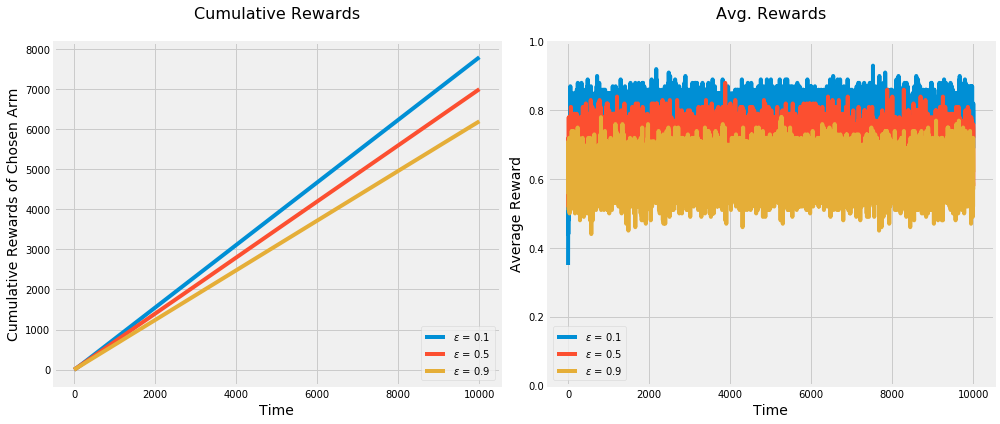

The max expectation rewards of epsilon-greedy is: 7788.510000000211


In [9]:
np.random.seed(1)

means = [0.4, 0.6, 0.8]

np.random.shuffle(means)

arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm_index = np.argmax(means)

epsilon = [0.1,0.5,0.9]

# Plot the result
print("mean:",means)
print("The best arm is #",best_arm_index+1,"arm with mean of",means[best_arm_index])

# Plot the algorithm
E1 = plot_algorithm(0,EpsilonGreedy, arms=arms, best_arm_index=best_arm_index,
               hyper_params=epsilon, num_simulations=T, horizon=N, label="$\epsilon$")
print("The max expectation rewards of epsilon-greedy is:",E1)

Then we can see the result that on average, the strategy with $\epsilon=0.1$ has the highest reward.

### B. UCB algorithm with c= 1,5,10

The **Upper Confidence Bounds (UCB) algorithm** measures the exploration of actions with a strong potential to have a optimal value by an upper confidence bound of the reward value.

This algorithm also contains four same processes with greedy algorithm.

In [10]:
class UCB:
    def __init__(self,c,counts=None,values=None):
        self.c = c
        self.counts = counts
        self.values = values
        self.t = 0

    def initialize(self,n_arms):
        self.counts = np.zeros(n_arms,dtype=int)
        self.values = np.zeros(n_arms,dtype=float)

    def select_arm(self):
        self.t+=1
        
        # Pick the best arm
        return np.argmax(self.values+self.c*np.sqrt(2*np.log(self.t)/(1+self.counts)))

    def update(self,chosen_arm,reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        self.values[chosen_arm] = value * ((n - 1) / n) + reward / n

mean: [0.4, 0.8, 0.6]
The best arm is # 2 arm with mean of 0.8


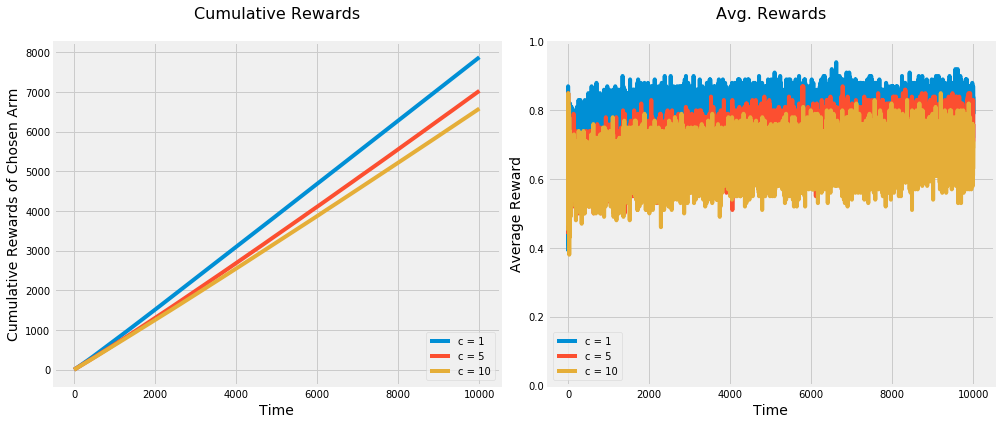

The max expectation rewards of UCB is: 7872.470000000287


In [11]:
np.random.seed(1)

means = [0.4, 0.6, 0.8]

np.random.shuffle(means)

arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm_index = np.argmax(means)

epsilon = [0.1,0.5,0.9]
c = [1,5,10]

# Plot the result
print("mean:",means)
print("The best arm is #",best_arm_index+1,"arm with mean of",means[best_arm_index])

# Plot the algorithm
E2 = plot_algorithm(1,UCB, arms=arms, best_arm_index=best_arm_index,
               hyper_params=c, num_simulations=T, horizon=N, label="c")
print("The max expectation rewards of UCB is:",E2)

Also, on average, the strategy with parameter c=1 performes better than others.

### C. Thompson Sampling 

**Thompson sampling** is an algorithm for online decision problems where actions are taken sequentially in a manner that must balance between exploiting what is known to maximize immediate performance and investing to accumulate new information that may improve future performance. The algorithm addresses a broad range of problems in a computationally eﬃcient manner and is therefore enjoying wide use. 

Thompson Sampling has the similar proccesses with the previous two.

In [12]:
class ThompsonSampling:
    def __init__(self,init_a,init_b,samples=None):
        self.init_a = init_a
        self.init_b = init_b
        self.samples = samples

    def initialize(self,n_arms):
        self.samples = np.zeros(n_arms,dtype=float)
        
    def select_arm(self):
        
        # Pick the best arm
        self.samples = [np.random.beta(self.init_a[x],self.init_b[x]) for x in range(n_arms)]
        return np.argmax(self.samples)
        
    def update(self,chosen_arm, reward):
        self.init_a[chosen_arm] += reward
        self.init_b[chosen_arm] += 1-reward

mean: [0.4, 0.8, 0.6]
The best arm is # 2 arm with mean of 0.8


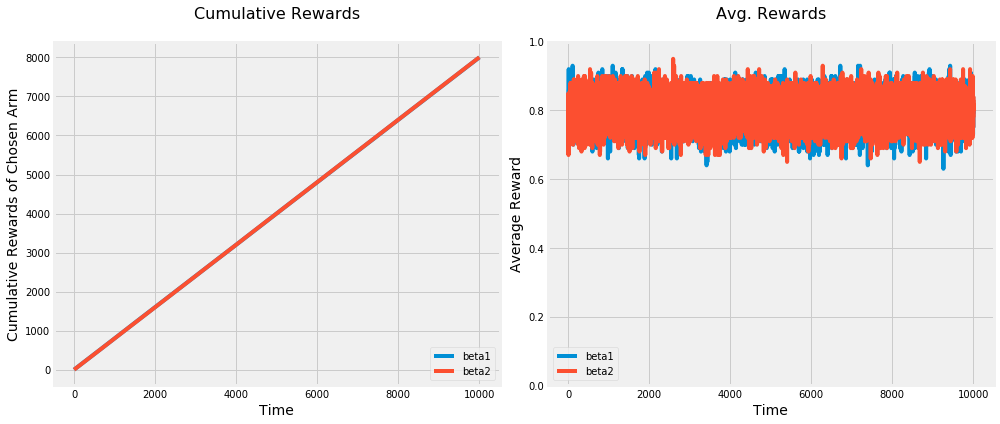

The max expectation rewards of Thompson Sampling is: 8003.350000000284


In [13]:
np.random.seed(1)

means = [0.4, 0.6, 0.8]

np.random.shuffle(means)

arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm_index = np.argmax(means)

epsilon = [0.1,0.5,0.9]
c = [1,5,10]
beta = [[[1,1,1],[1,1,1]],[[2,3,1],[4,6,2]]]

# Plot the result
print("mean:",means)
print("The best arm is #",best_arm_index+1,"arm with mean of",means[best_arm_index])

# Plot the algorithm
E3 = plot_algorithm(2,ThompsonSampling, arms=arms, best_arm_index=best_arm_index,
               hyper_params=beta, num_simulations=T, horizon=N, label="$\alpha \beta$")
print("The max expectation rewards of Thompson Sampling is:",E3)

We can see the strategy with parameter {($\alpha_1,\beta_1$)=(1,1),($\alpha_2,\beta_2$)=(1,1),($\alpha_3,\beta_3$)=(1,1)} performes better.

Next we plot the (posterior) probability of playing each arm.

In [14]:
from scipy.stats import beta
BANDIT_PROBABILITIES = [0.4, 0.6, 0.8]

class Bandit(object):
    def __init__(self, p):
        self.p = p
        self.a = 1
        self.b = 1

    def pull(self):
        return np.random.random() < self.p

    def sample(self):
        return np.random.beta(self.a, self.b)

    def update(self, x):
        self.a += x
        self.b += 1 - x
        
def plot(bandits, trial):
    x = np.linspace(0, 1, 1000)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label="real p: %.1f" % b.p)
    plt.title("Bandit distributions")
    plt.legend()

def experiment(sample_points):
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]

    for i in range(N):

        # take a sample from each bandit
        bestb = None
        maxsample = -1
        allsamples = []
       
        for b in bandits:
            sample = b.sample()
            allsamples.append("%.2f" % sample)
            if sample > maxsample:
                maxsample = sample
                bestb = b

        if i == sample_points:
            plot(bandits, N)

        # pull the arm for the bandit with the largest sample
        x = bestb.pull()

        # update the distribution
        bestb.update(x)

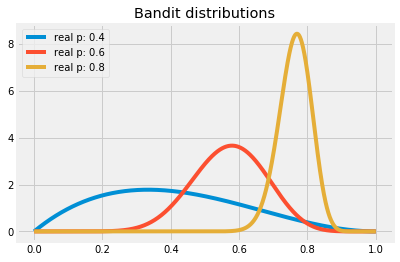

In [15]:
experiment(T)

## Step 3: Comparison and Results

### 1. Compare the results of three bandit algorithms

Let's review the values first.

In [16]:
print("The oracle value:",E_oracle,"\nExpectation of epsilon-Greedy:",E1,"\nExpectation of UCB:",E2,"\nExpectation of Thompson:",E3)

The oracle value: 7972 
Expectation of epsilon-Greedy: 7788.510000000211 
Expectation of UCB: 7872.470000000287 
Expectation of Thompson: 8003.350000000284


Then we compute the gaps between algorithm outputs and the oracle value.

In [17]:
print("Gap between epsilon-Greedy and the oracle value:",E1-E_oracle)
print("Gap between UCB and the oracle value:",E2-E_oracle)
print("Gap between Thompson and the oracle value:",E3-E_oracle)

Gap between epsilon-Greedy and the oracle value: -183.48999999978878
Gap between UCB and the oracle value: -99.52999999971325
Gap between Thompson and the oracle value: 31.350000000284126


The results show that **Thompson Sampling** performs best.

Then we need to compare the results directly with graphics. So we build a function to compare the algorithms.

In [18]:
ALGORITHMS = {"epsilon-Greedy": EpsilonGreedy, "UCB": UCB, "TS":ThompsonSampling}
def compare_algorithms(
        algorithms=None, arms=None, best_arm_index=None, num_simulations=1000,
        horizon=100, fig_size=(18, 6)):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Loop over all algorithms
    for algorithm in algorithms:
        
        # Run the algorithm
        algo = ALGORITHMS[algorithm[1]]
        if algorithm[1]=='TS':
            chosen_arms, average_rewards, cum_rewards = test_algorithm(algorithm[0],
                algo(algorithm[2][0],algorithm[2][1]), arms, num_simulations, horizon)
        else:
            chosen_arms, average_rewards, cum_rewards = test_algorithm(algorithm[0],
                algo(algorithm[2]), arms, num_simulations, horizon)
            
        # Plot
        axes[1].plot(average_rewards, label=algo.__name__)
        axes[1].set_xlabel("Time", fontsize=12)
        axes[1].set_ylabel("Average Reward", fontsize=12)
        axes[1].set_title(
            f"Average Rewards of Different Algorithms", y=1.05, fontsize=14)
        axes[1].set_ylim([0, 1.0])
        axes[1].legend(loc="lower right")
        axes[0].plot(cum_rewards, label=algo.__name__)
        axes[0].set_xlabel("Time", fontsize=12)
        axes[0].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=12)
        axes[0].set_title(
            f"Cumulative Rewards of Different Algorithms", y=1.05, fontsize=14)
        axes[0].legend(loc="lower right")
        plt.tight_layout()
    plt.show()

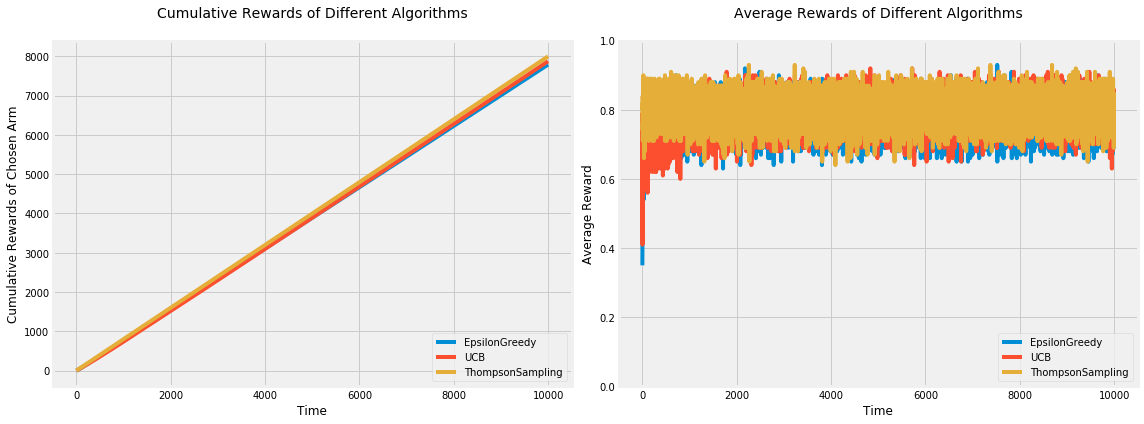

In [19]:
np.random.seed(1)

means = [0.4, 0.6, 0.8]

np.random.shuffle(means)

arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm_index = np.argmax(means)

algorithms=[[0,'epsilon-Greedy',0.1],[1,'UCB',1],[2,'TS',[[1,1,1],[1,1,1]]]]

# Compare the algorithms
compare_algorithms(algorithms, arms=arms, best_arm_index=best_arm_index, num_simulations=T, horizon=N)

From both the numerical results and the graphics, it is obvious that **ThompsonSampling** is the best, then is the UCB, epsilon-Greedy performs the worst among the three algorithm.

### 1. Impact of $\epsilon$, c, $\alpha_j,\beta_j$

#### $1^\circ$ $\epsilon$

From step 2, we find $\epsilon = 0.1$ performes best, and with the increasment of the value of $\epsilon$, the reward is less. So we can conclude that $\epsilon$ and the expected rewards have **negative correlation**.

#### $2^\circ$ c

The graphic in step 2 shows that when c=1, the bandit gets the most rewards, and with the increasment of the value of c, the reward is less. So we can conclude that c and the expected rewards have **negative correlation**.

#### $3^\circ \alpha_j, \beta_j$

We know that for Beta distribution, $\alpha$ means the number of success, $\beta$ means the number of failure. Then it is easy to understand that with **higher success rate $\frac{\alpha}{\alpha+\beta}$**, we will get more rewards.

# III Exploration-Exploitation in bandit algorithm

A simple example of Exploration & Exploitation is like one of our homework problems: you plan to eat N meals at a certain restaurant which has n dishes on the menu, assume if you had tried all the dishes you will rank them. Then if you choose to order your favorite dish every time you won't get to know about the other dishes; however if you choose to try new dish you will face a risk of having bad mood.  

The multi-armed bandit problem is a advanced problem with 3 restaurant in the scenario described above. Exploration means to gather more informationa but have a danger of loss. Exploitation means to make the best decision given current information but lose the chance of getting better rewards. The best long-term strategy may involve short-term sacrifices, and we need to gather enough information to make the best overall decisions.

# IV Futher Study - Dependent Case

We use Gaussian processes to model dependencies among arms.

Applying Gaussian processes is not straightforward, since the underlying utility function is not directly observable or does not exist. We instead use Gaussian processes to model the preference function f(b) corresponding to the preference of choosing b over the perfect “environment”of competing arms. Like in the independent arms case, the perfect environment corresponds to having all the remaining arms be deterministically selected as the best arm $b_1$: f(b) =P(b>b1). We model f(b) as a sample froma Gaussian process GP(μ(b),k(b,b′)). Note that this setup is analogous to the independent arms case, which uses a Beta prior to estimate the probability of each arm defeating the environment.

**Algorithm KERNELSELFSPARRING**

**input** Input space S, GP prior($\mu_0,\sigma_0$), m the numberof arms drawn at each iteration

 1:**for** t= 1,2,...**do**
 
 2:  **for** j= 1,...,m **do**
 
 3:   Sample $f_j$ from($\mu_{t-1},\sigma_{t-1}$)
 
 4:   Select $i_j(t)$ := $argmax_xf_j(x)$
 
 5:  **end for**
 
 6:  Play m arms $\{i_j(t)\}_j$, observe pairwise feedback matrix $R=\{r_{jk}∈\{0,1,∅\}\}_{m×m}$
 
 7:  **for** j,k= 1,...,m **do**
 
 8:   **if** $r_{jk}\neq ∅$ **then**
 
 9:     apply Bayesian update using $(i_j(t),r_{jk})$ to obtain $(\mu_t,\sigma_t)$
 
10:  **end if**

11: **end for**

12:**end for**

This algorithm describes KERNELSELFSPARRING, which instantiates SELFSPARRING using a Gaussian process Thompson sampling algorithm. The input space S can be continuous. At each iteration t, m arms are sampled using the Gaussian process prior $D_{t−1}$. The posterior $D_t$ is then updated by the responses R and the prior.

We conjecture that it is possible to prove no-regret guarantees that scale w.r.t.the dimensionality of the kernel. However, there does not yet exist suitable regret analyses for Gaussian Process Thompson Sampling in the kernelized MAB setting to leverage.

# Reference

[1] [epsilon-Greedy Algorithm](https://imaddabbura.github.io/post/epsilon-greedy-algorithm/)

[2] [The Multi-Armed Bandit Problem and Its Solutions](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html#case-study)

[3] [Bayesian A/B testing with Thompson sampling](https://zlatankr.github.io/posts/2017/04/07/bayesian-ab-testing)

[4] [Lecture 9: Exploration and Exploitation](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/XX.pdf)

[5] Yanan Sui,Vincent Zhuang,Joel W. Burdick,Yisong Yue."Multi-dueling Bandits with Dependent Arms"